<h1> Model training and evaluation for logo recognition </h1>

<p> <b> Author : </b> Yuvaraj Nagubandi </p>  

# Table of contents
1. [Introduction](#introduction)
2. [Training and evaluation](#analysis)
    1. [Imports and Function definitions](#definitions)
    2. [Analyse annotation data for any bad data](#analyzeannotation)
    3. [Read and study sample image](#readimage)
    4. [Define preprocessing function for images](#preprocessing)
    5. [Try bulding a baseline SVM model](#baselineMLModel)
    6. [Try tuning SVM model](#SVMTuning)
    7. [Build a neural network!](#NN)
    8. [Augument additional Train data using image data generator](#augmentdata)
    9. [Build neural network on agumented data](#NNTuning)
3. [Conclusions](#conclusion)
4. [Playground](#playground)


<h2> Introduction * </h2> <a name="introduction"></a>

<p> <b> Abstract/goal* : </b> This notebook is about training model to detect logos from multiple images available from flikr of the new target column,{ share_class_id }. </p> 
<p> <b> Details* : </b> The problem statement is to classify image to certain logo based on model trained from pre annotated dataset available in flickr
</p>
<p>



## Business Knowledge provided

Based on what has been provided, it can be seen that around 27 brand logos have been annotated and can be used for training with help of 607 images. The training dataset is quite less but still we can check the performances and take steps to incerase model efficency


## Import relavant libraries </h2> <a name="definitions"></a>

In [118]:
import warnings
warnings.filterwarnings("ignore")

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import sys
import PIL

from PIL import Image
from numpy import asarray 
from PIL import ImageOps
import pickle
from texttable import Texttable

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder


from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import np_utils
from keras.layers import core
from keras.layers import convolutional, pooling

In [120]:
pd.set_option('display.max_colwidth', -1)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Common evaluation function definitions used for model evaluation

In [186]:
# Defining functions to evaluate model performance 
def evaluate_model(X, y, pipeline, cv):
    skf = StratifiedKFold(n_splits = cv, random_state=42)
    train_scores, val_scores = {}, {}
    
    for g in (train_scores, val_scores):
        g['precision'] = []
        g['recall'] = []
        g['accuracy'] = []
        
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train, y_train)

        preds1 = pipeline.predict(X_train) # train set predictions
        train_scores['precision'].append(round(precision_score(y_train, preds1, average = 'weighted'), 4))
        train_scores['recall'].append(round(recall_score(y_train, preds1, average = 'weighted'), 4))
        train_scores['accuracy'].append(round(accuracy_score(y_train, preds1), 4))
        
        preds2 = pipeline.predict(X_val) # validation set predictions
        val_scores['precision'].append(round(precision_score(y_val, preds2, average = 'weighted'), 4))
        val_scores['recall'].append(round(recall_score(y_val, preds2, average = 'weighted'), 4))
        val_scores['accuracy'].append(round(accuracy_score(y_val, preds2), 4))
        
    return train_scores, val_scores


def plot_confusion_matrix(y_test,y_pred,labels, figsize = (20,20)):
    plt.figure(figsize=figsize)
    c_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred,labels = labels),columns = labels)
    c_matrix.set_index(labels, inplace = True)
    sns.heatmap(c_matrix, annot = True,fmt='g')


def classification_report(y_test,y_pred,labels):
    return metrics.classification_report(y_test, y_pred, labels = labels)


def print_metrics(y_test,y_pred):
    print(precision_score(y_test, y_pred, average = 'weighted'))
    print(recall_score(y_test, y_pred, average = 'weighted'))
    print(accuracy_score(y_test, y_pred))

## Load and analyse annotation data for any bad data <a name="analyzeannotation"></a>

Just loading and looking at annotation data to rectify any bad data

In [122]:
#load annotation information
annotation_info = pd.read_csv(r'flickr_logos_27_dataset\flickr_logos_27_dataset_training_set_annotation.txt',
                             sep = ' ',header = None,)
annotation_info

,0,1,2,3,4,5,6,7
0,144503924.jpg,Adidas,1,38,12,234,142,NaN
1,2451569770.jpg,Adidas,1,242,208,413,331,NaN
2,390321909.jpg,Adidas,1,13,5,89,60,NaN
3,4761260517.jpg,Adidas,1,43,122,358,354,NaN
4,4763210295.jpg,Adidas,1,83,63,130,93,NaN
...,...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54,NaN
4532,217288720.jpg,Yahoo,6,136,161,304,222,NaN
4533,2472817996.jpg,Yahoo,6,2,4,499,106,NaN
4534,2514220918.jpg,Yahoo,6,1,69,342,157,NaN


In [123]:
#Last column is unecessary, dropping them and rename as per business
annotation_info.drop(annotation_info.columns[len(annotation_info.columns)-1], axis=1, inplace=True)
annotation_info.columns=["image_name","brand","brand_id","x1","y1","x2","y2"]
annotation_info.head(5)

,image_name,brand,brand_id,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [124]:
#Check nulls
annotation_info.isnull().sum()

image_name    0
brand         0
brand_id      0
x1            0
y1            0
x2            0
y2            0
dtype: int64

There is no bad data, we can proceed ahead.

Lets check total sample of images per brand

Pepsi        389
Sprite       281
Cocacola     280
Vodafone     263
Apple        257
Adidas       256
Citroen      210
Unicef       190
Starbucks    188
Heineken     161
Nike         154
RedBull      141
Puma         131
Ford         131
McDonalds    124
Intel        123
Texaco       122
Porsche      120
Fedex        120
BMW          119
DHL          118
Google       117
Yahoo        115
HP           111
Mini         105
Nbc          105
Ferrari      105
Name: brand, dtype: int64


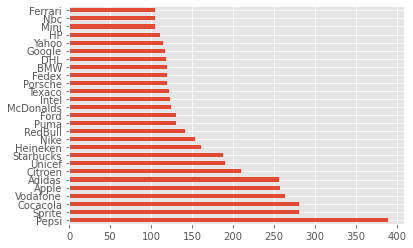

In [125]:
print(annotation_info.brand.value_counts())
annotation_info.brand.value_counts().plot(kind = 'barh')

It can be clearly seen that the data for training is quite less for each brand. The model can have an improved performance if there can be any increase in data synthetically or organically

In [126]:
#A function to load and give details of an image in  dataframe
def load_image(image_path,df,index,verbose = True):
    path = os.path.join(image_path,df['image_name'].iloc[index])
    img=Image.open(path)
    if verbose:
        print(path)
        print(img.format)
        print(img.size)
        print(img.mode)
    return img

## Read and inspect a random sample train Images <a name="readimage"></a>

A random image and its annotation values taken from dataset are fed just to check the image and understand

flickr_logos_27_dataset\flickr_logos_27_dataset_images\144503924.jpg
JPEG
(280, 210)
RGB


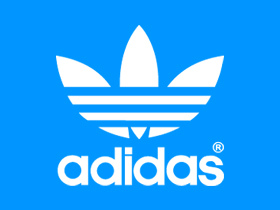

In [127]:
image_1 = load_image(r"flickr_logos_27_dataset\flickr_logos_27_dataset_images",annotation_info,0)
image_1

flickr_logos_27_dataset\flickr_logos_27_dataset_images\4763210295.jpg
JPEG
(500, 500)
RGB


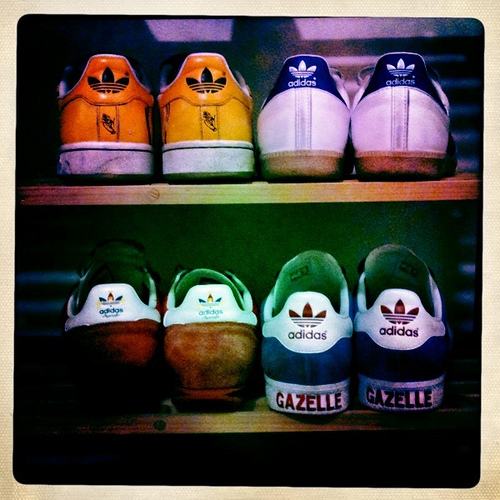

In [10]:
image_2 = load_image(r"flickr_logos_27_dataset\flickr_logos_27_dataset_images",annotation_info,10)
image_2

#### We can see that the images have different dimensions and shapes, we need preprocessing to be done in order to generalize all images to equal dimensions

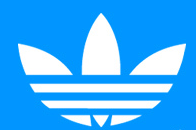

In [11]:
#Test preprocessing with image_1
# Cropped based on annotation
cropped_img = image_1.crop(box=(38,12,234,142))
cropped_img

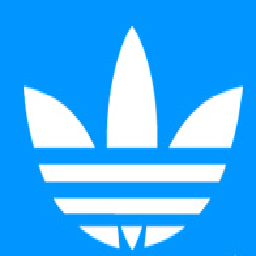

In [12]:
resized_image = cropped_img.resize((256,256))  #img.crop(box=(38,12,234,142))
resized_image

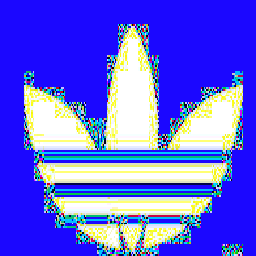

In [13]:
#lets equalize image to increase contrast at smaller details
equalize_image = ImageOps.equalize(resized_image) #img.crop(box=(38,12,234,142))
equalize_image

In [14]:
numpydata = asarray(equalize_image)
numpydata.shape

(256, 256, 3)

In [15]:
numpydata

array([[[ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255],
        ...,
        [ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255]],

       [[ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255],
        ...,
        [ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255]],

       [[ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255],
        ...,
        [ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255]],

       ...,

       [[ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255],
        ...,
        [ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255]],

       [[ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255],
        ...,
        [ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255]],

       [[ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255],
        ...,
        [ 27,   7, 255],
        [ 27,   7, 255],
        [ 27,   7, 255]]

In [16]:
annotation_info.columns

Index(['image_name', 'brand', 'brand_id', 'x1', 'y1', 'x2', 'y2'], dtype='object')

In [17]:
annotation_info.shape

(4536, 7)

## Define preprocessing function for preparing train data based on samples above <a name="preprocessing"></a>

#### The preprocessing looks good, building function to preprocess and store np array of all annotated image

In [128]:
def preprocess_image(df,images_directory = r"flickr_logos_27_dataset\flickr_logos_27_dataset_images",annotation='True',size = 16,equalize = True,as_df=True):
    images_data = []
    image_as_rows = []
    for i in range(df.shape[0]):
        image = load_image(images_directory,df,i,verbose= False)
        if annotation:
            
            data = list(annotation_info[['x1','y1','x2','y2']].iloc[i])
            image = image.crop(box=(data[0],data[1],data[2],data[3]))                           
            image = image.resize((size,size))
            image = ImageOps.equalize(image)
            image_data =  asarray(image,dtype='int32')
            row =  image_data.ravel().tolist()
            images_data.append(image_data)
            image_as_rows.append(row)
    images_df = pd.DataFrame.from_records(image_as_rows)
    if as_df:
        return images_data,images_df
    else:
        return images_data
    

In [92]:
os.path.exists(annotated_path)

True

In [151]:
working_dataset, images_df = preprocess_image(annotation_info)

In [152]:
images_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1,149,255,1,149,255,1,149,255,1,...,255,1,149,255,2,151,253,1,149,255
1,0,22,145,0,2,0,124,221,246,243,...,254,149,213,255,134,201,251,97,20,197
2,254,254,254,255,255,255,255,255,255,255,...,248,251,255,254,251,253,252,251,253,252
3,241,241,241,247,247,247,251,251,251,254,...,253,251,251,251,246,246,246,241,241,241
4,3,42,0,103,214,252,161,151,140,176,...,200,242,244,185,246,233,115,228,201,115


In [21]:
len(working_dataset)

4536

In [288]:
working_dataset = np.array(working_dataset)

##### Load unnanotated data set as well.

In [170]:
test_df = pd.read_csv("flickr_logos_27_dataset\\flickr_logos_27_dataset_query_set_annotation.txt",sep = '\t',header = None)

In [171]:
test_df.columns=["image_name","brand"]
test_df.head(5)

,image_name,brand
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas


In [212]:
test_df.brand.unique()

array(['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex',
       'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'McDonalds', 'Mini',
       'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite',
       'Starbucks', 'Intel', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo',
       'Nbc', 'none'], dtype=object)

In [213]:
test_df.shape

(270, 2)

Upon inspection, we also have none type in unannotated, lets remove none type data to properly annotate model

In [217]:
test_df = test_df[test_df.brand!='none']
test_df.shape

(135, 2)

In [218]:
query_dataset, query_images_df = preprocess_image(test_df)
query_dataset = np.array(query_dataset)

###  Lets check if images are properly processed

In [23]:
def build_image(image_array):
    ''' Build and show image from array'''
    plt.imshow(image_array)
    plt.axis('off')   
    plt.title("\nProcessed image\n", size=20)
    plt.show()

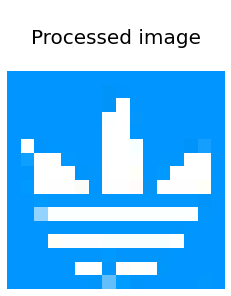

In [24]:
build_image(working_dataset[0])

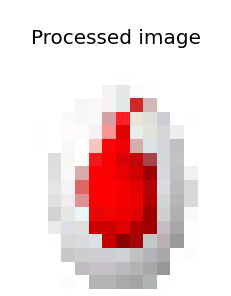

In [25]:
build_image(working_dataset[4312])

## Baseline SVM model on train data available <a name="baselineMLModel"></a>

In [344]:
X = images_df
y = annotation_info['brand']

#### Test train split

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 70,stratify=y)

#### Add steps to pipeline

In [347]:
model_pipe = Pipeline([('standardizer', MinMaxScaler()), 
                 ('model',  SVC(kernel="rbf",probability=True))])

In [163]:
train_scores, val_scores = evaluate_model(X,y,model_pipe,2)
table = Texttable()
table.header(['', 'Precision', 'Recall', 'Accuracy'])
table.add_row(['Train', np.mean(train_scores['precision']), np.mean(train_scores['recall']), np.mean(train_scores['accuracy'])])
table.add_row(['Val', np.mean(val_scores['precision']), np.mean(val_scores['recall']), np.mean(val_scores['accuracy'])])
print(table.draw())

+-------+-----------+--------+----------+
|       | Precision | Recall | Accuracy |
+=======+===========+========+==========+
| Train | 0.990     | 0.989  | 0.989    |
+-------+-----------+--------+----------+
| Val   | 0.944     | 0.941  | 0.941    |
+-------+-----------+--------+----------+


## The validation scores seem reasonably well for a subset of annotated data as test data at : 94% + performance scores

##### Lets build with params and check for unannotated data

In [348]:
classic_model = model_pipe.fit(X_train,y_train)

In [349]:
y_pred = classic_model.predict(X_test)

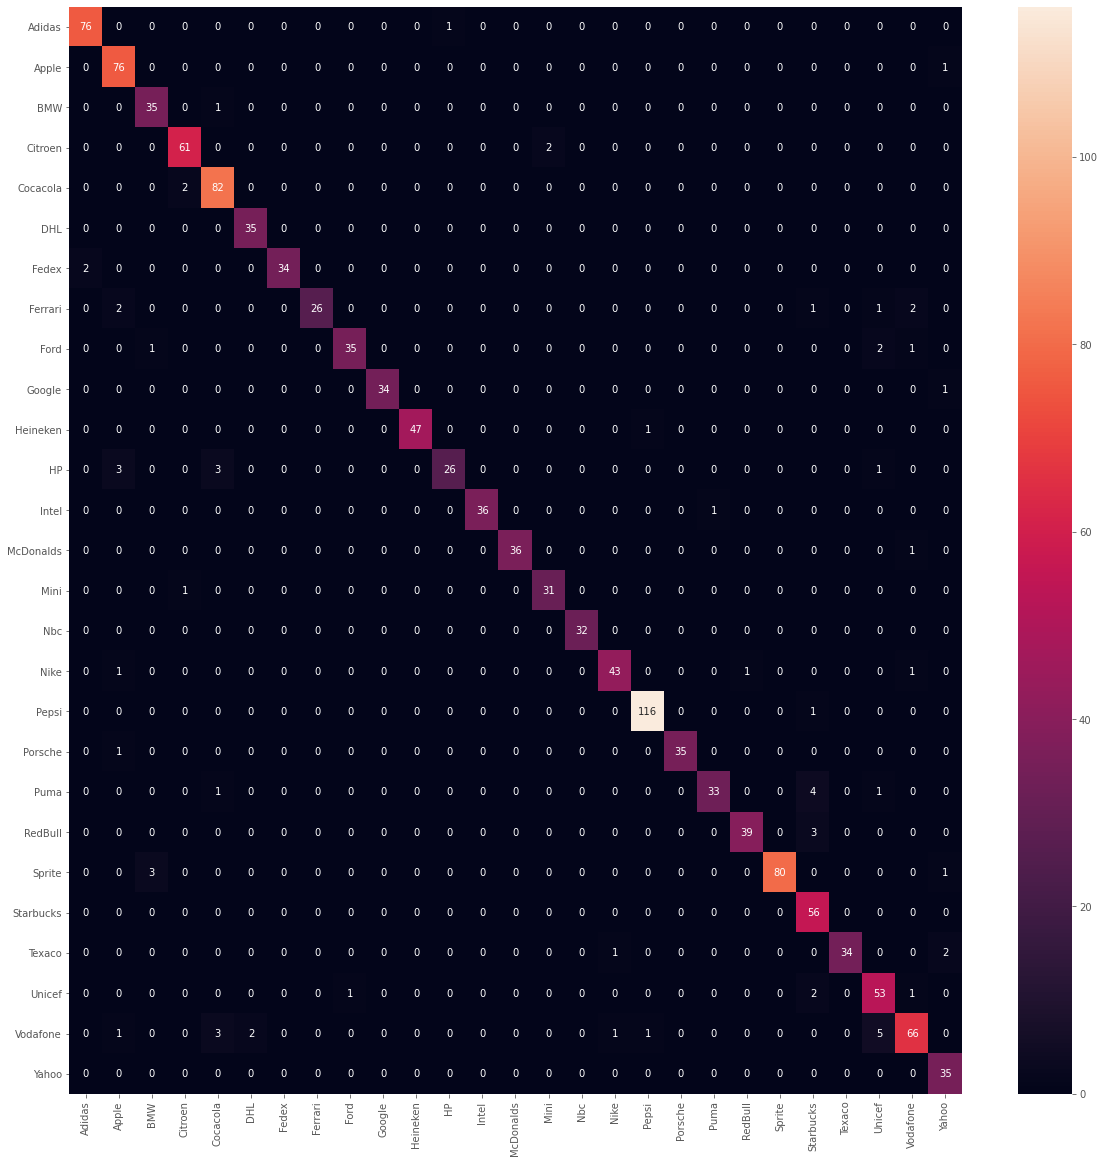

In [167]:
plot_confusion_matrix(y_test,y_pred,annotation_info['brand'].unique())

In [188]:
print_metrics(y_test,y_pred)

0.9522548351207656
0.9493019838354151
0.9493019838354151


##### performance with unnotated dataset

In [219]:
y_pred_unannotated = classic_model.predict(query_images_df)

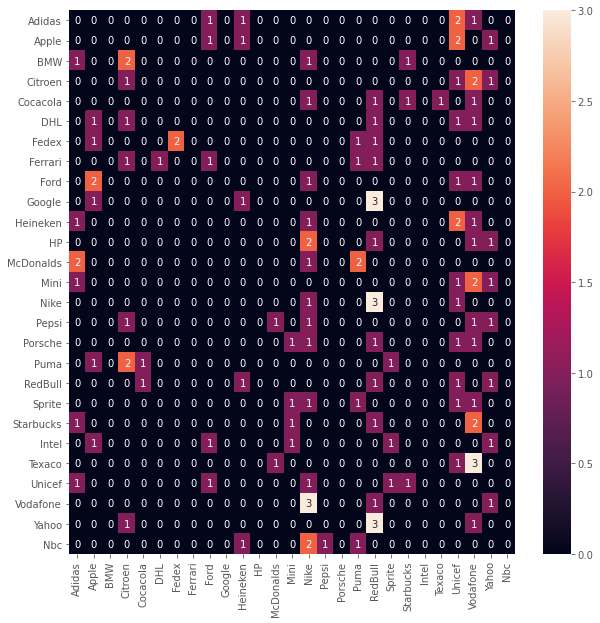

In [220]:
plot_confusion_matrix(test_df.brand,y_pred_unannotated,test_df.brand.unique(),figsize = (10,10))

In [221]:
print_metrics(test_df.brand,y_pred_unannotated)

0.04538852578068264
0.037037037037037035
0.037037037037037035


Though SVM gives 94% and recognizes quite well with direct logos fed, it is performing very bad with unnanotated and freestyle images where logo can be anywhere through out the image, which implies we need more training data for the model to work better or else as implied it could lead to overfit. If we have more training data then perhaps it can do better when fine tuned with hyperparameter tuning using gridsearch. 

Just trying the tuning part just in case.


<h2>Try a sample tuning for SVM</h2> <a name="SVMTuning"></a>

In [191]:
# specify number of folds for k-fold CV
n_folds = 5

# Create the parameter grid based on the results of random search 
param_grid = {
    'C': [1, 5, 10],
    'gamma': [0.0001,0.001,0.01]
}
# Create a based model
svm = SVC(kernel = 'rbf')
# Instantiate the grid search model
svm = GridSearchCV(estimator = svm, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)



svm.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   30.0s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01]},
             verbose=1)

In [192]:
print(svm.best_params_)
print(svm.best_score_)

{'C': 1, 'gamma': 0.0001}
0.8330712297092822


There is no much improvement seen from tweeking params and it needs more time for tuninng. Lets save the baseline model as a classical ML model for webservice and move forward with Deep learning.

In [ ]:
# Pickle the model : 
filename = 'svm_model.pkl'
pickle.dump(classic_model, open(filename, 'wb'))

## Build a neural network!  <a name="NN"></a>

Using keras for bulding a convolutional network for training and classifying the annotated data

In [322]:
X = working_dataset
y = annotation_info['brand']

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 70,stratify=y)

Label encode Y

In [324]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit(y_train)


In [325]:
target_labels = encoder.transform(y_train)

In [326]:
# Pickle encoder for usage in web application
filename = 'label_encoder_for_cnn.pkl'
pickle.dump(encoder, open(filename, 'wb'))

In [327]:
## Save labels and targets together.
import pandas as pd
target = pd.DataFrame(list(y_train),list(target_labels))
target = target.drop_duplicates()
target = target.reset_index()
target.columns = ['Encoded_Label','Original_Label']

In [328]:
target

,Encoded_Label,Original_Label
0,4,Cocacola
1,22,Starbucks
2,25,Vodafone
3,17,Pepsi
4,6,Fedex
5,3,Citroen
6,19,Puma
7,15,Nbc
8,23,Texaco
9,1,Apple


In [329]:
y_train_to_cat = np_utils.to_categorical(target_labels).reshape(target_labels.shape[0],-1)

In [330]:
y_train_to_cat.shape

(3175, 27)

In [331]:
X_train.shape

(3175, 16, 16, 3)

#### Building a simple neural network for the 16px images

In [332]:
model = Sequential()
model.add(convolutional.Conv2D(32, (2, 2), activation='relu', input_shape=(16,16,3)))

model.add(convolutional.Conv2D(20, (3, 3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(core.Dropout(0.25))

model.add(core.Flatten())
model.add(core.Dense(128, activation='relu'))
model.add(core.Dropout(0.5))

model.add(core.Dense(27, activation='softmax'))

In [333]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [334]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 15, 15, 32)        416       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 20)        5780      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 20)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 6, 20)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               92288     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)              

In [335]:
history = model.fit(X_train, y_train_to_cat, batch_size=32, epochs=100)

Epoch 1/100
100/100 [==============================] - 1s 8ms/step - loss: 46.2922 - accuracy: 0.0727
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 3.3003 - accuracy: 0.0844
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 3.2360 - accuracy: 0.0969
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 3.1431 - accuracy: 0.1203
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 3.0761 - accuracy: 0.1356
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 3.0262 - accuracy: 0.1482
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 2.9738 - accuracy: 0.1619
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 2.9009 - accuracy: 0.1874
Epoch 9/100
100/100 [==============================] - 1s 8ms/step - loss: 2.9107 - accuracy: 0.1812
Epoch 10/100
100/100 [==============================] - 1s 8ms/step - loss: 2.8194 - accur

100/100 [==============================] - 1s 9ms/step - loss: 0.4073 - accuracy: 0.8794
Epoch 82/100
100/100 [==============================] - 1s 9ms/step - loss: 0.4030 - accuracy: 0.8823
Epoch 83/100
100/100 [==============================] - 1s 9ms/step - loss: 0.4133 - accuracy: 0.8794
Epoch 84/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3858 - accuracy: 0.8887
Epoch 85/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3845 - accuracy: 0.8964
Epoch 86/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3911 - accuracy: 0.8911
Epoch 87/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3668 - accuracy: 0.8998
Epoch 88/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3581 - accuracy: 0.9006
Epoch 89/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3552 - accuracy: 0.8991
Epoch 90/100
100/100 [==============================] - 1s 9ms/step - loss: 0.3875 - accuracy: 

In [304]:
predictions = model.predict_classes(X_train)

In [305]:
predictions

array([ 4, 22, 25, ...,  4, 16,  2], dtype=int64)

In [306]:
# calculate train accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(target_labels, predictions)

0.9930708661417322

In [307]:
predictions_test = model.predict_classes(X_test)

In [308]:
encoded_y_test = encoder.transform(y_test)

In [309]:
metrics.accuracy_score(encoded_y_test, predictions_test)

0.9493019838354151

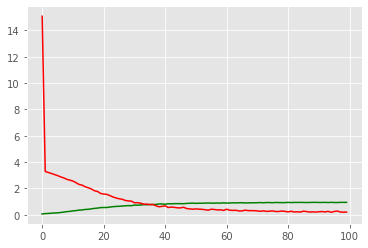

In [310]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['loss'],'r')

Neural network gave a great performance of 96% on test annotated data which is a great improvement compared with classical model gives 94% and recognizes quite well with direct logos fed,but still 99.9% in train means it is learning too much, but it could be a good advantage if we are only trying to build logo detector based on logos.

Lets also see if there is any improvement with unnanotated and freestyle images where logo can be anywhere through out the image.


In [64]:
model.save("./models/CNNModel.h5")

In [311]:
y_pred_unannotated = model.predict_classes(query_dataset)

In [312]:
encoded_y_test_unannotated = encoder.transform(test_df.brand)

In [313]:
metrics.accuracy_score(encoded_y_test_unannotated, y_pred_unannotated)

0.037037037037037035

Still not doing great with free style images. Lets try to add some more data to dataset by trying to augument multiple versions of same image w.r.t. changes in image dimentions and features.


<h2>Augment more images to training Neural network</h2> <a name="augmentdata"></a>

In [314]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
vertical_flip=False) # randomly flip images

In [ ]:
model = Sequential()
model.add(convolutional.Conv2D(32, (2, 2), activation='relu', input_shape=(16,16,3)))

model.add(convolutional.Conv2D(20, (3, 3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2)))
model.add(core.Dropout(0.25))

model.add(core.Flatten())
model.add(core.Dense(128, activation='relu'))
model.add(core.Dropout(0.5))

model.add(core.Dense(27, activation='softmax'))

In [315]:
gen_flow=datagen.flow(X_train,y_train_to_cat,batch_size=27,seed=0)

<h2> Building neural net on augmented train</h2> <a name="NNTuning"></a>

In [316]:
hist=model.fit_generator(gen_flow,steps_per_epoch=len(X_train) / 128, epochs=500)

Epoch 1/500
24/24 [==============================] - 0s 9ms/step - loss: 5.0679 - accuracy: 0.2948
Epoch 2/500
24/24 [==============================] - 0s 10ms/step - loss: 3.6465 - accuracy: 0.1437
Epoch 3/500
24/24 [==============================] - 0s 9ms/step - loss: 3.2894 - accuracy: 0.1526
Epoch 4/500
24/24 [==============================] - 0s 10ms/step - loss: 3.2099 - accuracy: 0.1837
Epoch 5/500
24/24 [==============================] - 0s 10ms/step - loss: 3.0698 - accuracy: 0.1943
Epoch 6/500
24/24 [==============================] - 0s 10ms/step - loss: 2.9120 - accuracy: 0.2252
Epoch 7/500
24/24 [==============================] - 0s 10ms/step - loss: 2.7961 - accuracy: 0.2578
Epoch 8/500
24/24 [==============================] - 0s 9ms/step - loss: 2.6934 - accuracy: 0.2830
Epoch 9/500
24/24 [==============================] - 0s 10ms/step - loss: 2.8473 - accuracy: 0.2726
Epoch 10/500
24/24 [==============================] - 0s 9ms/step - loss: 2.6378 - accuracy: 0.2874
Epo

24/24 [==============================] - 0s 10ms/step - loss: 1.5036 - accuracy: 0.5541
Epoch 83/500
24/24 [==============================] - 0s 9ms/step - loss: 1.5193 - accuracy: 0.5526
Epoch 84/500
24/24 [==============================] - 0s 9ms/step - loss: 1.5508 - accuracy: 0.5541
Epoch 85/500
24/24 [==============================] - 0s 9ms/step - loss: 1.4994 - accuracy: 0.5719
Epoch 86/500
24/24 [==============================] - 0s 9ms/step - loss: 1.4675 - accuracy: 0.5956
Epoch 87/500
24/24 [==============================] - 0s 9ms/step - loss: 1.4555 - accuracy: 0.5926
Epoch 88/500
24/24 [==============================] - 0s 9ms/step - loss: 1.6119 - accuracy: 0.5557
Epoch 89/500
24/24 [==============================] - 0s 9ms/step - loss: 1.4644 - accuracy: 0.5807
Epoch 90/500
24/24 [==============================] - 0s 9ms/step - loss: 1.5242 - accuracy: 0.5763
Epoch 91/500
24/24 [==============================] - 0s 9ms/step - loss: 1.6144 - accuracy: 0.5422
Epoch 92/500

24/24 [==============================] - 0s 10ms/step - loss: 1.2011 - accuracy: 0.6385
Epoch 164/500
24/24 [==============================] - 0s 10ms/step - loss: 1.2654 - accuracy: 0.6205
Epoch 165/500
24/24 [==============================] - 0s 11ms/step - loss: 1.1692 - accuracy: 0.6491
Epoch 166/500
24/24 [==============================] - 0s 11ms/step - loss: 1.2291 - accuracy: 0.6370
Epoch 167/500
24/24 [==============================] - 0s 10ms/step - loss: 1.1204 - accuracy: 0.6696
Epoch 168/500
24/24 [==============================] - 0s 11ms/step - loss: 1.2381 - accuracy: 0.6476
Epoch 169/500
24/24 [==============================] - 0s 10ms/step - loss: 1.1305 - accuracy: 0.6815
Epoch 170/500
24/24 [==============================] - 0s 11ms/step - loss: 1.2188 - accuracy: 0.6446
Epoch 171/500
24/24 [==============================] - 0s 10ms/step - loss: 1.0817 - accuracy: 0.6711
Epoch 172/500
24/24 [==============================] - 0s 10ms/step - loss: 1.2232 - accuracy: 0

24/24 [==============================] - 0s 12ms/step - loss: 0.8838 - accuracy: 0.7289
Epoch 244/500
24/24 [==============================] - 0s 12ms/step - loss: 1.0273 - accuracy: 0.6815
Epoch 245/500
24/24 [==============================] - 0s 12ms/step - loss: 1.0444 - accuracy: 0.7111
Epoch 246/500
24/24 [==============================] - 0s 12ms/step - loss: 0.9931 - accuracy: 0.6978
Epoch 247/500
24/24 [==============================] - 0s 12ms/step - loss: 1.0182 - accuracy: 0.7022
Epoch 248/500
24/24 [==============================] - 0s 11ms/step - loss: 0.9340 - accuracy: 0.7126
Epoch 249/500
24/24 [==============================] - 0s 11ms/step - loss: 0.9846 - accuracy: 0.7199
Epoch 250/500
24/24 [==============================] - 0s 11ms/step - loss: 0.9463 - accuracy: 0.6919
Epoch 251/500
24/24 [==============================] - 0s 12ms/step - loss: 0.9697 - accuracy: 0.7244
Epoch 252/500
24/24 [==============================] - 0s 11ms/step - loss: 0.9830 - accuracy: 0

24/24 [==============================] - 0s 12ms/step - loss: 0.8763 - accuracy: 0.7393
Epoch 323/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8898 - accuracy: 0.7410
Epoch 324/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8749 - accuracy: 0.7393
Epoch 325/500
24/24 [==============================] - 0s 11ms/step - loss: 0.9037 - accuracy: 0.7407
Epoch 326/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8620 - accuracy: 0.7511
Epoch 327/500
24/24 [==============================] - 0s 11ms/step - loss: 0.7764 - accuracy: 0.7600
Epoch 328/500
24/24 [==============================] - 0s 11ms/step - loss: 0.8594 - accuracy: 0.7541
Epoch 329/500
24/24 [==============================] - 0s 12ms/step - loss: 0.8708 - accuracy: 0.7393
Epoch 330/500
24/24 [==============================] - 0s 11ms/step - loss: 1.0001 - accuracy: 0.6978
Epoch 331/500
24/24 [==============================] - 0s 12ms/step - loss: 0.8286 - accuracy: 0

24/24 [==============================] - 0s 11ms/step - loss: 0.7615 - accuracy: 0.7570
Epoch 403/500
24/24 [==============================] - 0s 12ms/step - loss: 0.7876 - accuracy: 0.7748
Epoch 404/500
24/24 [==============================] - 0s 12ms/step - loss: 0.7546 - accuracy: 0.7926
Epoch 405/500
24/24 [==============================] - 0s 12ms/step - loss: 0.8039 - accuracy: 0.7659
Epoch 406/500
24/24 [==============================] - 0s 13ms/step - loss: 0.8418 - accuracy: 0.7570
Epoch 407/500
24/24 [==============================] - 0s 12ms/step - loss: 0.8331 - accuracy: 0.7570
Epoch 408/500
24/24 [==============================] - 0s 12ms/step - loss: 0.8303 - accuracy: 0.7467
Epoch 409/500
24/24 [==============================] - 0s 12ms/step - loss: 0.7548 - accuracy: 0.7526
Epoch 410/500
24/24 [==============================] - 0s 13ms/step - loss: 0.7245 - accuracy: 0.7837
Epoch 411/500
24/24 [==============================] - 0s 13ms/step - loss: 0.7876 - accuracy: 0

24/24 [==============================] - 0s 10ms/step - loss: 0.8242 - accuracy: 0.7575
Epoch 483/500
24/24 [==============================] - 0s 10ms/step - loss: 0.8961 - accuracy: 0.7496
Epoch 484/500
24/24 [==============================] - 0s 10ms/step - loss: 0.6602 - accuracy: 0.8089 0s - loss: 0.6688 - accuracy: 0.
Epoch 485/500
24/24 [==============================] - 0s 10ms/step - loss: 0.8195 - accuracy: 0.7733
Epoch 486/500
24/24 [==============================] - 0s 10ms/step - loss: 0.6410 - accuracy: 0.8117
Epoch 487/500
24/24 [==============================] - 0s 10ms/step - loss: 0.8307 - accuracy: 0.7437
Epoch 488/500
24/24 [==============================] - 0s 10ms/step - loss: 0.8805 - accuracy: 0.7452
Epoch 489/500
24/24 [==============================] - 0s 10ms/step - loss: 0.7600 - accuracy: 0.7748
Epoch 490/500
24/24 [==============================] - 0s 10ms/step - loss: 0.8162 - accuracy: 0.7689
Epoch 491/500
24/24 [==============================] - 0s 11ms/

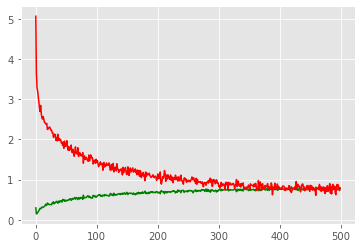

In [317]:
plt.plot(hist.history['accuracy'],'g')
plt.plot(hist.history['loss'],'r')

In [319]:
y_pred_unannotated = model.predict_classes(query_dataset)

In [342]:
y_proba =  model.predict_proba(query_dataset)

In [343]:
y_proba

array([[5.21309376e-01, 2.53120740e-03, 3.55391414e-03, ...,
        1.64186960e-04, 1.78287097e-03, 9.58315741e-06],
       [1.03112226e-02, 4.76518571e-02, 4.19694174e-04, ...,
        2.50561908e-02, 9.50826332e-02, 1.19134299e-01],
       [2.31794380e-02, 2.84997834e-04, 3.09518044e-04, ...,
        6.33627549e-02, 8.56824408e-05, 4.01615762e-05],
       ...,
       [9.14704578e-04, 6.26204088e-02, 1.63985060e-05, ...,
        2.14842893e-02, 4.05037940e-01, 8.58594477e-03],
       [4.90926446e-08, 1.42129560e-04, 3.03615744e-11, ...,
        9.57160024e-13, 1.12268513e-04, 6.23217431e-07],
       [1.77677907e-02, 1.13247134e-01, 1.15354720e-03, ...,
        2.14917175e-02, 7.41961524e-02, 2.17070729e-01]], dtype=float32)

In [339]:
query_dataset[0]

array([[[229, 244, 253],
        [241, 246, 253],
        [214, 240, 251],
        [199, 113, 131],
        [145,  47,  51],
        [107,  40,  80],
        [ 26,  43,  73],
        [143,  59,  64],
        [139,  47,  58],
        [152,  71,  84],
        [110,  65, 107],
        [173,  87, 117],
        [166,  79,  96],
        [180,  79, 105],
        [186,  90, 113],
        [181,  84, 101]],

       [[230, 240, 251],
        [235, 244, 254],
        [212, 240, 248],
        [198, 127, 145],
        [ 37,  36,  61],
        [ 15,  35,  52],
        [126,  51,  65],
        [126,  55,  78],
        [156,  59,  92],
        [152,  71,  95],
        [139,  65,  88],
        [152,  71,  94],
        [130,  69,  85],
        [139,  68,  99],
        [171,  99, 122],
        [163,  79, 100]],

       [[214, 241, 249],
        [226, 245, 253],
        [212, 239, 250],
        [177,  71,  57],
        [ 15,  39,  49],
        [  8,  39,  46],
        [116,  45,  58],
        [163,  80,  9

In [320]:
encoded_y_test_unannotated = encoder.transform(test_df.brand)

In [321]:
metrics.accuracy_score(encoded_y_test_unannotated, y_pred_unannotated)

0.08148148148148149

#### There seems to be a great improvement to detecting freestyle images but it comes with a cost as the detection power on annotated images as reduced to a great extent from 90 to 77. The loss function also recovered well with more epochs. 

Saving this model as well as it has a better performance for freestyle images. The model can be further improved over more amount of data and applying image processing techniques

In [336]:
model.save("./models/CNNModel_freestyle.h5")

 ## Conclusions <a name="conclusion"></a>

The annotated data found for annotation is good enough to train models which can be used for recognizing the brand on the logo itself but it is having lesser performance on freestyle images where the logo is randomly placed accross an image.

The Classical ML also performs quite good in comparision with Neural net but it has the least capability on freestyle images.


Recommendations and further scope :

There can be couple of stratigies that can be done to improve prediction in freestyle as well.

1. The image can be split into different sub sections and the prediction can be done on each subsection and based on the proba score we can try predicting the values.

2. More data agumentation can be done to make the model learn all the logos well even in different stratigic positions like flipped, rotated, cropped etc

3. More pictures can be annotated to increase the amount of train data which will also improve model performance.

4. Last but not the least, the model paramaters can be tweaked in combination with above reccomendations (Hyperparamater tuning), and different other algorithms can be used to check and improve the performance.




## Webservice  Details:

The models prepared above are used for building the webservice.

The service can be containerized and models can also be directly fetched from cloud storage service like AWS S3 or directly managed by deploying it in the Sagemaker multimodel inference. 

The service for now is prepared according to Flask and heroku deployment along with a Docker File incase of quick containerization and hosting.

It could be hosted in heroku but the slug size crosses the free tier of 500 MB as the service includes heavy weight frameworks like Tensorflow for using neural network.

I do not have accessability to cloud services on a personal subscription basis, thus I am leaving the code in the local but ready to be deployed. Added to that, I can also deploy the service as and when required when provided with adequate infrastructure or cloud services.


This is a UI driven service but it can be further added with provisions to insertion to database, an API etc according to requirement

# Playground  (For ruff work) <a name="Playground"></a>

In [ ]:
# Save some sample cropped images locally 
def save_cropped_images(df,images_directory = r"flickr_logos_27_dataset\flickr_logos_27_dataset_images" ):
    
    annotated_path = os.path.join(images_directory,'annotated_images')
            
    if os.path.exists(annotated_path):
        if len(os.listdir(annotated_path))!=0:
            for f in os.listdir(annotated_path):
                os.remove(f)
    else : 
        os.mkdir(os.path.join(images_directory,'annotated_images'))
        
    for i in range(df.shape[0]):
        image = load_image(images_directory,df,i,verbose= False) 
        data = list(annotation_info[['x1','y1','x2','y2']].iloc[i])
        image = image.crop(box=(data[0],data[1],data[2],data[3]))
        image.save(os.path.join(annotated_path,annotation_info['image_name'].iloc[i]))
        


In [ ]:
save_cropped_images(annotation_info)

### Testing Preprocessing function for webservice

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sys

from PIL import Image
from numpy import asarray 
from PIL import ImageOps
from texttable import Texttable

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score


def iterate_through_images():
    images = os.listdir(r'.\images')
    image_df = pd.DataFrame(images)
    image_df.columns=["image_name"]
    return image_df


def load_image(image_path,df,index,verbose = True):
    path = os.path.join(image_path,df['image_name'].iloc[index])
    img=Image.open(path)
    if verbose:
        print(path)
        print(img.format)
        print(img.size)
        print(img.mode)
    return img


def preprocess_image(images_directory = r".\images",annotation='False',size = 16,equalize = True,as_df=True):
    images_data = []
    image_as_rows = []
    df = iterate_through_images()
    for i in range(df.shape[0]):
        image = load_image(images_directory,df,i,verbose= False)

        # if annotation:
        #     data = list(df[['x1','y1','x2','y2']].iloc[i])
        #     image = image.crop(box=(data[0],data[1],data[2],data[3]))

        image = image.resize((size,size))
        image = ImageOps.equalize(image)
        image_data =  asarray(image,dtype='int32')
        row =  image_data.ravel().tolist()
        images_data.append(image_data)
        image_as_rows.append(row)
    images_df = pd.DataFrame.from_records(image_as_rows)

    if as_df:
        return images_data,images_df
    else:
        return images_data


In [213]:
model = Sequential()

model.add(Convolution2D(filters=32,kernel_size=(3,3),input_shape=(64,32,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(output_dim=256,activation='relu'))
model.add(Dense(output_dim=27,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

TypeError: __init__() missing 1 required positional argument: 'units'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

"""
Tensorboard log
"""
log_dir = './tf-log/'
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
cbks = [tb_cb]

model.fit_generator(
    train_generator,
    samples_per_epoch=samples_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=cbks,
    validation_steps=validation_steps)

target_dir = './models/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('./models/model.h5')
model.save_weights('./models/weights.h5')

#Calculate execution time
end = time.time()
dur = end-start

if dur<60:
    print("Execution Time:",dur,"seconds")
elif dur>60 and dur<3600:
    dur=dur/60
    print("Execution Time:",dur,"minutes")
else:
    dur=dur/(60*60)
    print("Execution Time:",dur,"hours")

In [220]:
X_train.shape

(3175, 16, 16, 3)

In [51]:
annotation_info['image_name'].iloc[4]

'4763210295.jpg'

flickr_logos_27_dataset\flickr_logos_27_dataset_images\3294282629.jpg
JPEG
(500, 461)
RGB


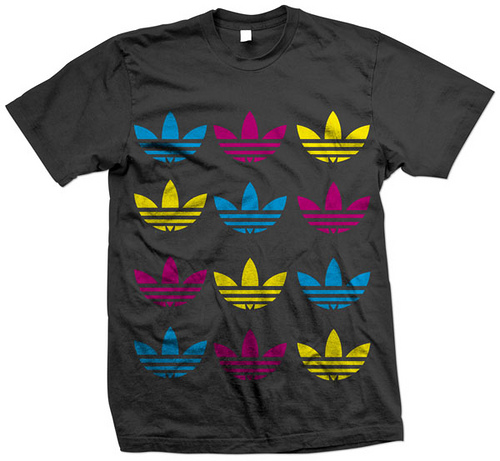

In [67]:
image2 = load_image(r"flickr_logos_27_dataset\flickr_logos_27_dataset_images",annotation_info,)
image2

In [207]:
X = working_dataset
y = annotation_info['brand']

In [ ]:
train = ImageDataGenerator(rescale=1./255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
zca_whitening=True, # Apply ZCA whitening
rotation_range=20, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest',
validation_split=0.2)

valid = ImageDataGenerator(rescale=1./255)

HEIGHT = 32
WIDTH = 64
BATCH_SIZE = 64


trainset = train.flow_from_directory("FLICK2/",
target_size = (WIDTH,HEIGHT),
batch_size = BATCH_SIZE,
shuffle=True,
seed=42,
color_mode='rgb',
classes=y,
class_mode='categorical')

validset = valid.flow_from_directory("FLICK2/",
target_size = (WIDTH,HEIGHT),
batch_size = BATCH_SIZE,
shuffle=True,
seed=42,
color_mode='rgb',
classes=y,
class_mode = 'categorical')

In [208]:
model = Sequential()

model.add(Convolution2D(filters=32,kernel_size=(3,3),input_shape=(64,32,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(output_dim=256,activation='relu'))
model.add(Dense(output_dim=27,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

TypeError: __init__() missing 1 required positional argument: 'units'